<a href="https://colab.research.google.com/github/atlaie/Case-Studies/blob/main/Music%2520Classification/Project_Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music classification and generation with spectrograms

* Alejandro Tlaie
* Maria Royo
* Carlos Vivar
* Frank Sierra

---
## Setup

In [3]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install wandb --quiet
!pip install optuna --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00


In [4]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import optuna
import wandb

In [5]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [6]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

In [7]:
os.environ["WANDB_START_METHOD"] = "thread"
STUDY_NAME = "winningKaggle"
wandb.login() #Only if you're not logged in.

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Sample minimum length

In [8]:
import glob

lens = []
samples = []
for file in glob.glob('Data/genres_original/*/*.wav'):
  if file != 'Data/genres_original/jazz/jazz.00054.wav':
    y, sample_rate = librosa.load(file)
    lens.append(np.shape(y)[0])
    samples.append(sample_rate)

minL = np.min(lens)

## Convert songs into spectrograms


In [9]:
# Short-time Fourier transform (STFT). We have checked how changing each parameter (n_fft and hop_length; window size in which to 
# perform the transform and jump between windows, respectively) modify the spectrogram. The former shouldn't be changed for music
# analyses, it's a standard window (93ms at 22050 Hz); may be interesting to change for other audio signals. The latter determines the
# spectrogram resolution (inversely proportional). We've checked that massively reducing the hop (from 512 to 16) just increases the computation
# time without actually yielding much improvement (we've also tried zooming in to check that's the case).

def calc_spectrogram(audio, path, length, sr = 22050, dpi = 30):

  #S = librosa.feature.melspectrogram(audio[:length], sr = sr, n_mels=323, hop_length=512*4)
  S = librosa.feature.melspectrogram(y = audio[:length], sr = sr)
  S_DB = librosa.amplitude_to_db(S, ref = np.max)
  # np.save(path + '.npy', S_DB[np.newaxis])


  fig, ax = plt.subplots(figsize = (15, 10))
  fig.canvas.draw()

  librosa.display.specshow(S_DB, sr = sr, hop_length = 512,
                          x_axis='time',cmap='gray_r')
  
  
  ax.set_axis_off()
  plt.tight_layout()
  plt.savefig(path + '.tif', dpi = dpi, bbox_inches = 'tight', pad_inches = 0.0)
  # Clear the current axes.
  plt.cla() 
  # Clear the current figure.
  plt.clf() 
  # Closes all the figure windows.
  plt.close('all')

In [10]:
import glob
import os
import librosa

try:
  os.mkdir('Data/spectrograms')
except:
  pass

for file in glob.glob('Data/genres_original/*/*.wav'):
  if file != 'Data/genres_original/jazz/jazz.00054.wav':
    #print(file)
    y, sample_rate = librosa.load(file)

    basename = file.split('/')[-1]
    genre = basename.split('.')[0]
    sample = basename.split('.')[1]

    try:
      os.mkdir('Data/spectrograms/{}'.format(genre))
    except:
      pass

    calc_spectrogram(y, 'Data/spectrograms/{}/{}{}'.format(genre,genre,sample), minL)

In [ ]:
## Compress data
#import shutil
#shutil.make_archive('spectrograms_grayscale', 'zip', 'Data/spectrograms')

## Train a CNN with optuna

In [11]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  train_loss = [t.tolist() for t in train_loss]
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [12]:
device = set_device()

GPU is enabled in this notebook.


In [13]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/spectrograms/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.tif"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]  #Aqui tenemos 10 de test,
  val_files = src_file_paths[10:20]  #10 de validation
  train_files = src_file_paths[20:]  #10 train

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [14]:
# Data loading.

train_dataset = datasets.ImageFolder(train_dir,transforms.Compose([transforms.ToTensor(), transforms.Grayscale()]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 25, shuffle = True, num_workers = 0)

val_dataset = datasets.ImageFolder(val_dir,transforms.Compose([transforms.ToTensor(), transforms.Grayscale()]))

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 25, shuffle = True, num_workers = 0)

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from optuna.trial import TrialState


class musicNet(nn.Module):
    """CNN for the MNIST dataset of handwritten digits.
    Attributes:
        - convs (torch.nn.modules.container.ModuleList):   List with the convolutional layers
        - conv2_drop (torch.nn.modules.dropout.Dropout2d): Dropout for conv layer 2
        - out_feature (int):                               Size of flattened features
        - fc1 (torch.nn.modules.linear.Linear):            Fully Connected layer 1
        - fc2 (torch.nn.modules.linear.Linear):            Fully Connected layer 2
        - p1 (float):                                      Dropout ratio for FC1
    Methods:
        - forward(x): Does forward propagation
    """
    def __init__(self, trial, drop_conv2, drop_fc1):
        """Parameters:
            - trial (optuna.trial._trial.Trial): Optuna trial
            - num_conv_layers (int):             Number of convolutional layers
            - num_filters (list):                Number of filters of conv layers
            - num_neurons (int):                 Number of neurons of FC layers
            - drop_conv2 (float):                Dropout ratio for conv layer 2
            - drop_fc1 (float):                  Dropout ratio for FC1
        """

        super(musicNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)

        self.convs = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]
        self.fc1 = nn.Linear(in_features = 768, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 10)

        self.batchnorm1 = nn.BatchNorm2d(num_features = 8)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 16)
        self.batchnorm3 = nn.BatchNorm2d(num_features = 32)
        self.batchnorm4 = nn.BatchNorm2d(num_features = 64)
        self.batchnorm5 = nn.BatchNorm2d(num_features = 128)
        self.batchNorms = [self.batchnorm1, self.batchnorm2, self.batchnorm3, self.batchnorm4, self.batchnorm5]

        self.dropout = nn.Dropout(p = drop_fc1, inplace = False)
        self.conv2_drop = nn.Dropout2d(p = drop_conv2)

        # Initialize weights with the He initialization
        for i in range(1, len(self.convs)):
            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
            if self.convs[i].bias is not None:
                nn.init.constant_(self.convs[i].bias, 0)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        """Forward propagation.
        Parameters:
            - x (torch.Tensor): Input tensor of size [N,1,28,28]
        Returns:
            - (torch.Tensor): The output tensor after forward propagation [N,10]
        """
        for i, conv_i in enumerate(self.convs):  # For each convolutional layer
          # print(i)
          if np.logical_and(i>0, i<len(self.convs)-1):  # Add dropout if layer 2
              x = self.conv2_drop(F.relu(self.batchNorms[i](F.max_pool2d(conv_i(x), 2))))  # Conv_i, max-pooling, Batch Normalization, RelU, Dropout
          else:
              x = F.relu(self.batchNorms[i](F.max_pool2d(conv_i(x), 2)))                   # Conv_i, max-pooling, Batch Normalization, RelU

        x = torch.flatten(x, 1)                                           # Flatten tensor
        x = F.relu(self.fc1(x))                                    # FC1, RelU
        # x = F.dropout(x, p = self.p1, training = self.training)  # Apply dropout after FC1 only when training
        x = self.fc2(x)                                            # FC2, RelU

        return F.log_softmax(x, dim=1)                       # log(softmax(x))


def train(network, optimizer):
    """Trains the model.
    Parameters:
        - network (__main__.Net):              The CNN
        - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
    Returns:
        - mean loss
        - training accuracy 
    """
    network.train()  # Set the module in training mode (only affects certain modules)
    loss_list = []
    correct = 0

    for batch_i, (data, target) in enumerate(train_loader):  # For each batch
        # Limit training data for faster computation
        if batch_i * batch_size_train > number_of_train_examples:
            break

        optimizer.zero_grad()                                 # Clear gradients
        output = network(data.to(device))                     # Forward propagation
        loss = F.nll_loss(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))
        loss.backward()                                       # Compute gradients
        optimizer.step()                                      # Update weights
        # loss_list.append(loss.cpu().detach().numpy())

        # Accuracy calculation
        output = network(data.to(device))               # Forward propagation
        pred = output.data.max(1, keepdim = True)[1]      # Find max value in each row, return indexes of max values
        # print(data.shape, pred.shape, output.shape, target.shape)
        correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions
        # print(batch_i)

    accuracy_train = correct / len(train_loader.dataset)                                    
    loss_return = F.nll_loss(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))

    return  accuracy_train, loss_return

def test(network):
    """Tests the model.
    Parameters:
        - network (__main__.Net): The CNN
    Returns:
        - accuracy_test (torch.Tensor): The test accuracy
        - loss_test 
    """
    network.eval()         # Set the module in evaluation mode (only affects certain modules)
    correct = 0
    with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
        loss_list = []
        for batch_i, (data, target) in enumerate(val_loader):  # For each batch

            # Limit testing data for faster computation
            if batch_i * batch_size_test > number_of_test_examples:
                break

            output = network(data.to(device))               # Forward propagation
            
            pred = output.data.max(1, keepdim = True)[1]      # Find max value in each row, return indexes of max values
            correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions

    accuracy_test = correct / len(val_loader.dataset)
    loss_test = F.nll_loss(output, target.to(device))
    return accuracy_test, loss_test#np.mean(loss_list)

def objective(trial):
    """Objective function to be optimized by Optuna.
    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of convolutional layers, number of filters of
    convolutional layers, number of neurons of fully connected layers.
    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    # Define range of values to be tested for the hyperparameters
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.35)        # Dropout for convolutional layer 2
    drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.35)            # Dropout for FC1 layer

    # Generate the model
    model = musicNet(trial, drop_conv2,  drop_fc1).to(device)

    # Generate the optimizers
    optimizer_name = 'Adam'
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)                                                     # Learning rates
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-1, log=True)                                 # L2 penalty
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr = lr, weight_decay = weight_decay)

    # init tracking experiment.
    # hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init(
        project="optuna_150epochs_100trials_smallOptimization_25072022",
        entity="nma_schnitzer",  # NOTE: this entity depends on your wandb account.
        config=config,
        group=STUDY_NAME,
        reinit=True,
    )

    # Training of the model
    for epoch in range(n_epochs):
        train_accuracy, train_loss = train(model, optimizer)  # Train the model
        val_accuracy, val_loss = test(model)   # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(val_accuracy, epoch)

        # report validation accuracy to wandb
        wandb.log(data={"validation accuracy": val_accuracy,
                        "validation loss": val_loss,
                        "training accuracy": train_accuracy,
                        "training loss": train_loss}, step=epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()


    # report the final validation accuracy to wandb
    wandb.run.summary["final accuracy"] = val_accuracy
    wandb.run.summary["state"] = "completed"
    wandb.finish(quiet=True)

    return val_accuracy


if __name__ == '__main__':

    # -------------------------------------------------------------------------
    # Optimization study for a PyTorch CNN with Optuna
    # -------------------------------------------------------------------------

    # Use cuda if available for faster computations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Parameters ----------------------------------------------------------
    n_epochs = 150                          # Number of training epochs
    batch_size_train = 25                  # Batch size for training data
    batch_size_test = 25                   # Batch size for testing data
    number_of_trials = 100                 # Number of Optuna trials
    limit_obs = True                       # Limit number of observations for faster computation

    # *** Note: For more accurate results, do not limit the observations.
    #           If not limited, however, it might take a very long time to run.
    #           Another option is to limit the number of epochs. ***

    if limit_obs:  # Limit number of observations
        number_of_train_examples = 50 * batch_size_train  # Max train observations
        number_of_test_examples = 5 * batch_size_test      # Max test observations
    else:
        number_of_train_examples = 60000                   # Max train observations
        number_of_test_examples = 10000                    # Max test observations
    # -------------------------------------------------------------------------

    # Make runs repeatable
    random_seed = 1
    torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
    torch.manual_seed(random_seed)

    # Create directory 'files', if it doesn't exist, to save the dataset
    directory_name = 'files'
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

  # Data loading.

    train_dataset = datasets.ImageFolder(train_dir,transforms.Compose([transforms.ToTensor(), transforms.Grayscale()]))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size_train, shuffle = True, num_workers = 0)
    val_dataset = datasets.ImageFolder(val_dir,transforms.Compose([transforms.ToTensor(), transforms.Grayscale()]))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size_train, shuffle = True, num_workers = 0)
    test_dataset = datasets.ImageFolder(test_dir,transforms.Compose([transforms.ToTensor(), transforms.Grayscale()]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size_test, shuffle = True, num_workers = 0)



    # Create an Optuna study to maximize test accuracy
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials = number_of_trials)

    # -------------------------------------------------------------------------
    # Results
    # -------------------------------------------------------------------------

    # Find number of pruned and completed trials
    pruned_trials = study.get_trials(deepcopy = False, states = [TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy = False, states = [TrialState.COMPLETE])

    # Display the study statistics
    print("\nStudy statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    trial = study.best_trial
    print("Best trial:")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save results to csv file
    df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
    df = df.loc[df['state'] == 'COMPLETE']          # Keep only results that did not prune
    df = df.drop('state', axis=1)                   # Exclude state column
    df = df.sort_values('value')                    # Sort based on accuracy
    # df.to_csv('optuna_results.csv', index=False)  # Save to csv file

    # Display results in a dataframe
    print("\nOverall Results (ordered by accuracy):\n {}".format(df))

    # Find the most important hyperparameters
    most_important_parameters = optuna.importance.get_param_importances(study, target=None)

    # Display the most important hyperparameters
    print('\nMost important hyperparameters:')
    for key, value in most_important_parameters.items():
        print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))

## Results visualization

Here, I show the top-100 runs (sorted by validation accuracy) pooled together. 
Each run is a different hyperparameter optimization run (based on Optuna: https://optuna.org/), thus converging to slightly different solutions.

As can be seen, the validation accuracy is 52±4.2%. Given that there are 10 different categories (music genres) to be predicted and that they are almost completely balanced, random predictions would yield a 10% accuracy. Thus, we greatly outperform the random (and majority class) model.

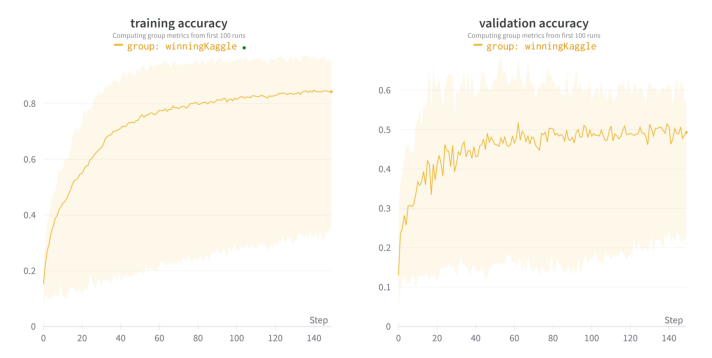

In [35]:
import matplotlib.image as mpimg
import seaborn as sns

images = []
images.append(mpimg.imread('/content/Training_accuracy.png'))
images.append(mpimg.imread('/content/Validation_accuracy.png'))
plt.figure(figsize=(10,10))
columns = len(images)
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left = True, bottom = True)
plt.tight_layout()
